### TDSE: Time Dependent Schrodinger Equation 1D
$$
i\hbar \frac{\partial \psi (x,t)}{\partial t} = \frac{-\hbar^2}{2m} \frac{\partial^2 \psi (x,t)}{\partial x} + V(x,t) \psi (x,t)
\\
i\frac{\partial \psi}{\partial t'} = -\frac{1}{2}\frac{\partial^2 \psi}{\partial x'^2 } + V'(x)\psi
$$
#### Finite diferenece
$$
i\frac{\psi^{m+1}_{j} + \psi^{m}_{j}}{\Delta t} = -\frac{1}{2} \frac{\psi^{m}_{j+1} -2\psi^{m}_{j} + \psi^{m}_{j-1}}{\Delta x ^2} + V(x)\psi^{m}_{j} 
$$
$\psi$ of next time step at the position $j$
$$
\psi^{m+1}_{j} = \psi^{m}_{j} + \frac{i\Delta t}{2\Delta x^2}[\psi^{m}_{j+1} -2\psi^{m}_{j} + \psi^{m}_{j-1}] -i\Delta t V(x) \psi^{m}_{j} 
$$

## Gauusian wave packets equation
$\hbar$ and $m = 1$
$$
\psi_x(x,t = 0) = \left(\frac{1}{2\pi\sigma^2_x}\right)^\frac{1}{4} exp(ip_0x -\frac{(x-x_0)^2}{4\sigma^2_x})
$$

## Position, Momentum and Energy
### Operators
$$
\braket{o} = \int{}{} \psi^* o \psi dx 
$$
position
$$
\hat{x} = x
$$
linear momentum
$$
\hat{p} = -i\hbar\frac{\partial}{\partial x}
$$
Energy
$$
\hat{H} = -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + V(x)
$$


In [137]:
# requirements and imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import sparse
import os


In [172]:
# System parameters 
N = 301
# positive length
L = 10
# grid
x,dx = np.linspace(0,L, N , retstep= True)
# time parameters
Nt = 20000
dt = 1e-5

In [139]:
# gaussain wave package generator
def gen_gaussian(x,x0,sigma, p0):
    A = (1 / (2 * np.pi * sigma**2))**(0.25)
    B = np.exp((-(x-x0)**2) / ((2 * sigma)**2))
    C = np.exp(1j*p0*x)
    return A * B * C

# standing wave generator
def gen_sine(x, n):
    A = np.sqrt(2/(L))
    k = np.pi/(L)
    return np.sin(n*k*x)

# potential
def V_2(x):
    return 1/2 * x 

def V_free_particle(x):
    return x * 0 

def V_well(x):
    mu ,sigma = 5 , 2
    A = -1e2
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def V_harmonic(x,x0 = 5,k = 1/10):
    return 1/2 * k * (x-x0)**2 

def V_barrier(x,peak):
    arr = x.copy()
    arr[:] = 0 
    left = int(len(x) * 1/2)
    right = int(len(x) * (1/2 + 1/100)) 
    arr[left:right]  = peak
    return arr

def V_step(x,peak = 50):
    arr = x.copy()
    arr[:] = 0 
    left = int(len(x) * 1/2)
    arr[left:]  = peak
    return arr

# position operator
def get_position(psi):
    op_x = np.conj(psi) * x * psi
    return integrate.simps(op_x,x)

# momentum operator
def get_momentum(psi):
    op_p = np.conj(psi) * -1j * np.gradient(psi,1)
    return  integrate.simps(op_p,x)

# Energy 
def get_e(psi,V):
    d2 = np.gradient(np.gradient(psi,x),x)
    ke = - 1/2 * d2
    po = V * psi
    op_e = np.conj(psi) * (ke + po)
    return integrate.simps(op_e,x)

# probability density
def density(psi):
    return psi * np.conj(psi)

#normalize wave function
def normalize(psi, x):
    sum_psi_sq = integrate.simps(abs(psi)**2 , x)
    # print('normalize factor A = ', sum_psi_sq)
    return (np.sqrt(1/sum_psi_sq))

# check normalization
def check_normal(psi):
    psi_n = integrate.simps(abs(psi)**2 , x)
    return psi_n - 1 < 1e-9



## FD method

In [147]:
# compute psi[t+1] and normalise
def get_psi(psi,V):
    psi_next = np.zeros(N,dtype='cfloat')
    for i in range(1,len(psi)-1):
        # print(f'{psi[i]},{1j/2 * dt/dx**2 * (psi[i+1] - 2*psi[i] + psi[i-1])},{1j*dt*V(psi[i])*psi[i]}')
        psi_next[i] = psi[i] + (1j/2 * dt/dx**2 * (psi[i+1] - 2*psi[i] + psi[i-1])) - (1j*dt*V[i]*psi[i])
    psi_next = normalize(psi_next,x) * psi_next 
    return psi_next

# stack all psi[t] into big matrix
def simulation(psi,V):
    t = 0
    psi_tot = psi.copy()
    while t < Nt:
        psi = get_psi(psi,V)
        psi_tot = np.vstack((psi_tot,psi))
        t = t + 1 

    return psi_tot

## Crank-Nicolson method

In [141]:

def alpha():
    # defining alpha
    return (1j * dt) / (4 * (dx**2))
def a_b():
    # defining diagonal a and b
    a = (1 + (2 * alpha()))
    b = (1 - (2 * alpha()))
    return a , b 

# constant matrix :-> MA, MM
def constant_matrix(V):
    a ,b = a_b()
    dia = np.ones([N])
    dia_A = np.array([dia * -alpha() , dia *a, dia * -alpha()])
    V0= sparse.diags(-1j * dt *V)
    dia_M = np.array([dia * alpha() , dia * b , dia * alpha()])
    MA = sparse.spdiags(dia_A,np.array([-1,0,1]),N,N)
    MM = sparse.spdiags(dia_M,np.array([-1,0,1]),N,N)  + V0
    return MA , MM


def CMN(psi0,V):
    psi = np.zeros([Nt,N]).astype(complex)
    psi[0] = psi0
    MA , MM = constant_matrix(V)
    t = 0 
    y = psi0.copy()
    while t < Nt-1:
        MR = sparse.csr_matrix.dot(MM, y)
        psi_next = sparse.linalg.spsolve(MA, MR)
        psi_next = normalize(psi_next,x) * psi_next
        psi[t+1] = psi_next
        y = psi_next
        t += 1    
    return psi

In [173]:
# psi0 as gaussian
psi = gen_gaussian(x, x0 = 3 , sigma = 1/2 , p0 = 25)

# #psi0 as sine
# psi = gen_sine(x,1)
# psi2 = gen_sine(x,2)
# potential init
V0 = V_barrier(x,peak = 500)

C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-1.0, 1.0)

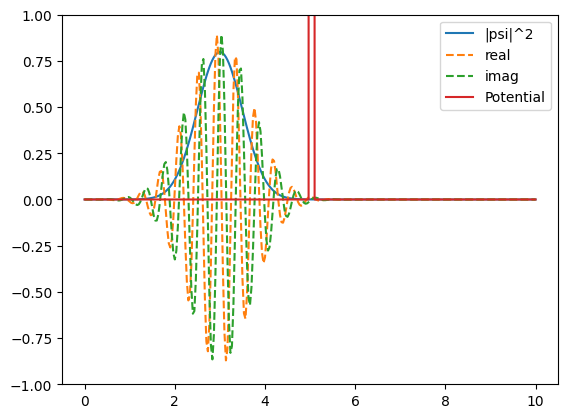

In [163]:
plt.plot(x, density(psi), label = '|psi|^2')
plt.plot(x, psi.real, '--', label = 'real')
plt.plot(x, psi.imag, '--', label = 'imag')

plt.plot(x,V0, label = 'Potential')
plt.legend()
plt.ylim(-1,1)
# save plot
# file_format = 'png'
# file_name = f'Initial wave barrier'

# directory = '/Users/Windows10/Desktop/schrodinger/animation'
# output_file = os.path.join(directory, f'{file_name}.{file_format}')
# plt.savefig(output_file)

In [176]:
# simulation
psi_m00 = simulation(psi.astype(complex),V0)

In [174]:
psi_m11 = CMN(psi,V0)

C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


## Animation

C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Windows10\AppData\Local\Temp\ipykernel_14500\2907297103.py:25: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return f'position <x> {round(get_position(psi_mm[sframe,:]),3).real}'
C:\Users\Windows10\AppData\Local\Temp\ipykernel_14500\2907297103.py:28: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return f'momentum <p> {round(get_momentum(psi_mm[sframe,:]),3).real}'
C:\Users\Windows10\AppData\Local\Temp\ipykernel_14500\2907297103.py:

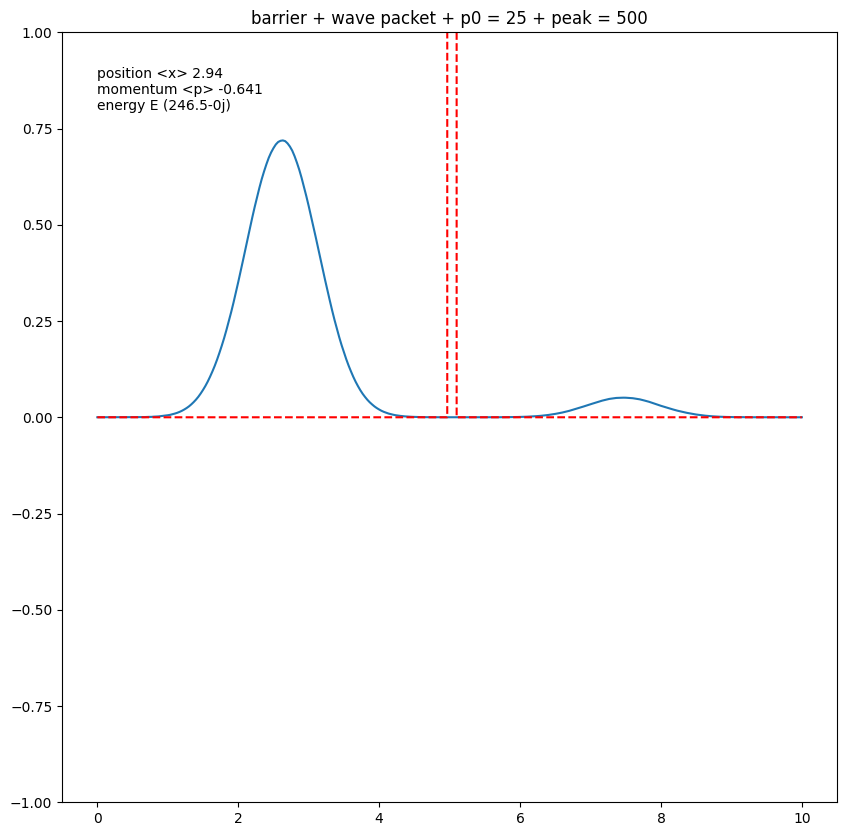

In [249]:
# animation
from matplotlib.animation import FuncAnimation
import os
import sys
# method used
method = "CNM"

if method == "FD":
    psi_mm = psi_m00
elif method == "CNM":
    psi_mm = psi_m11
else:
    print("Error, wrong method")
    sys.exit()

# initial setup
fig,ax = plt.subplots(figsize  = (10,10))
line, = ax.plot(x,density(psi_mm[0,:]))
line2, = ax.plot(x, V0 , '--' ,color = 'r')
frame_skip = 20
title = "barrier + wave packet + p0 = 25 + peak = 500"

#calculate position
def text_pos(sframe):
    return f'position <x> {round(get_position(psi_mm[sframe,:]),3).real}'
#calculate momentum
def text_momentum(sframe):
    return f'momentum <p> {round(get_momentum(psi_mm[sframe,:]),3).real}'
#calculate Energy
def text_energy(sframe):
    return f'energy E {round(get_e(psi_mm[sframe,:],V0),2)}'
txt = ax.text(0 , 0.85 ,f'{text_pos(0)} \n{text_momentum(0)} \n{text_energy(0)}', ha='left', va='center', fontsize=10, color="black")
plt.title(title)
plt.ylim(-1,1)

# function update 1d wave over time
def update(frame):
    line.set_ydata(density(psi_mm[frame_skip * frame,:]))
    txt.set_text(f'{text_pos(frame_skip*frame)} \n{text_momentum(frame_skip*frame)} \n{text_energy(frame_skip * frame)}')
    return line, txt,



#number of frames 
nframes = len(psi_mm) // frame_skip

ani = FuncAnimation(fig,update, frames = nframes, interval = 1, blit = True)


# save animation
file_format = 'gif'
file_name = f'{method} 1D TDSE {title}'

directory = '/Users/Windows10/Desktop/schrodinger/animation'
output_file = os.path.join(directory, f'{file_name}.{file_format}')

ani.save(output_file, writer='pillow', fps=15)

plt.show()


## Plots

C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\

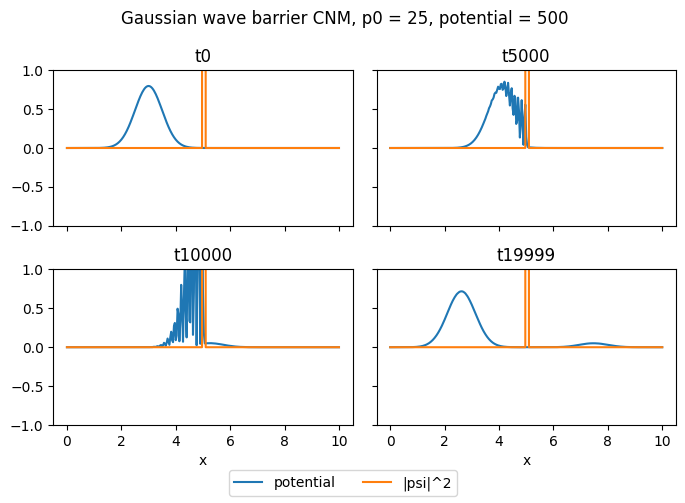

In [247]:
Method = 'CNM'

if Method == 'FD':
    psi_mm = psi_m00
elif Method == 'CNM':
    psi_mm = psi_m11
else:
    print("ERROR")
    sys.exit()

fig, axs = plt.subplots(2, 2, figsize=(7,5), sharex=True, sharey=True,
                        constrained_layout=False)
fig.suptitle(f'Gaussian wave barrier {Method}, p0 = 25, potential = 500')

# labels and times
labels = ['potential' ,'|psi|^2']
times = [0,5000,10000,19999]

# plotting subplot with different data
axs = axs.ravel()
for i,ts in enumerate(times):
    axs[i].plot(x, density(psi_mm[ts]) ,label= labels[1])
    axs[i].set_title(f't{ts}')

# plotting subplot with same data across all subplots
for ax in axs.flat:
    ax.plot(x,V0, label = labels[0])
    ax.set_ylim(-1,1)
    ax.set_xlabel("x")
    ax.label_outer()

fig.tight_layout() 
fig.subplots_adjust(bottom=0.15) 
fig.legend(labels=labels, loc="lower center", ncol = len(labels))
plt.show()


# save plot
# file_format = 'png'
# file_name = f'Gaussian wave harmonic {Method}, p0 = 0'

# directory = '/Users/Windows10/Desktop/schrodinger/animation'
# output_file = os.path.join(directory, f'{file_name}.{file_format}')
# plt.savefig(output_file)